## Importação das Bibliotecas

In [60]:
import numpy as np
import cv2
import zipfile
import os
import matplotlib.pyplot as plt
from PIL import Image
# from google.colab.patches import cv2_imshow

## Carregamento da base de Dados

In [61]:
path = './datasets/yalefaces.zip'
with zipfile.ZipFile(file = path, mode = 'r') as z:
    z.extractall('./datasets/')

In [137]:
pasta_treino = './datasets/yalefaces/train/'
pasta_teste = './datasets/yalefaces/test/'
pasta = [os.path.join(pasta_treino, f) for f in os.listdir(pasta_treino)]

## Detectando Faces (DNN)

In [138]:
# Carrega o modelo pré-treinado para detecção facial
network = cv2.dnn.readNetFromCaffe('./datasets/weights/deploy.prototxt.txt',
                                  './datasets/weights/res10_300x300_ssd_iter_140000.caffemodel')

# Limite de confiança mínimo para detecção de rosto
conf_min = 0.7

# Função para realizar a detecção facial
def detector_facial(network, path, conf=False):
    # Abre a imagem em escala de cinza usando a biblioteca PIL
    imagem = Image.open(path).convert('L')
    # Converte a imagem para uma matriz NumPy
    imagem_np = np.array(imagem, dtype='uint8')
    # Converte a imagem de escala de cinza para BGR usando o OpenCV
    imagem = cv2.cvtColor(imagem_np, cv2.COLOR_GRAY2BGR)
    # Cria uma cópia da imagem original para processamento
    imagem_cp = imagem.copy()
    # Obtém as dimensões da imagem
    (h, w) = imagem_np.shape[:2]
    # Pré-processa a imagem para a entrada do modelo
    blob = cv2.dnn.blobFromImage(cv2.resize(imagem, (100, 100)), 1.0, (100, 100), (104.0, 117.0, 123.0))
    # Envia a imagem blob para camada de entrada da Rede Neural
    network.setInput(blob)
    # Realiza a detecção
    deteccoes = network.forward()

    roi = None  # Inicializa a variável ROI como None
    for i in range(0, deteccoes.shape[2]):
        # Busca a confianca da imagem
        confianca = deteccoes[0, 0, i, 2]
        
        if confianca > conf_min:
            # Cria uma caixa delimitadora na detecção da imagem
            bbox = deteccoes[0, 0, i, 3:7] * np.array([w, h, w, h])
            (start_x, start_y, end_x, end_y) = bbox.astype('int')
            # Cria uma regiao de interesse pelo boundbox
            roi = imagem_cp[start_y:end_y, start_x:end_x]
            # Redimensiona o roi
            roi = cv2.resize(roi, (60, 80))
            # Criar uma variavel e armazena a confiança 
            text = f'{(confianca):.4f}'
            # Desenha uma texto com o valor da confiança
            if conf == True:
                cv2.putText(imagem, text, (start_x, start_y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 255, 0), 2)
            # Desenha um retangulo na imagem na regiao de interesse no caso a detecção Facial
            cv2.rectangle(imagem, (start_x, start_y), (end_x, end_y), (0, 255, 0), 1)
    
    # Verifica se roi não é None antes de prosseguir
    if roi is not None:
        # Converte a ROI para escala de cinza
        
        face = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
        roi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    # Retorna a imagem com as detecções e a última ROI processada
    return imagem, roi


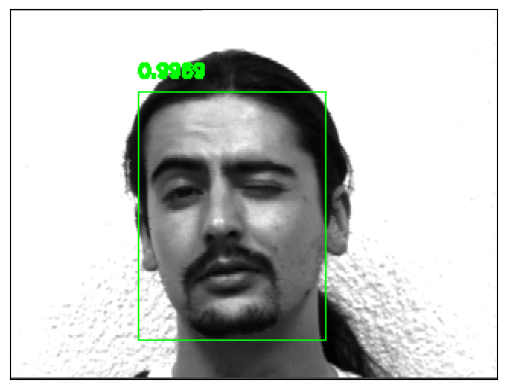

In [140]:
imagem, roi = detector_facial(network, pasta[80], conf=True)
plt.imshow(imagem)
plt.xticks(())
plt.yticks(())
plt.show()

## Criando Base de Dados em Treino e Teste

In [141]:
pasta_treino = './datasets/yalefaces/train/'
pasta_teste = './datasets/yalefaces/test/'
pasta = [os.path.join(pasta_teste, f) for f in os.listdir(pasta_teste)]

In [143]:
def get_image_data(path):
    paths = [os.path.join(path, f) for f in os.listdir(path)]
    faces = []
    ids = []
    
    for path in paths:
#         imagem = Image.open(path).convert('L')
#         roi = np.array(imagem)
        imagem, roi = detecor_facial(network, path)
        id = int(os.path.basename(path).split('.')[0][-2:])
        faces.append(roi)
        ids.append(id)
        
    return faces, np.array(ids)

In [144]:
faces_treino, ids_treino = get_image_data(pasta_treino)
faces_teste, ids_teste = get_image_data(pasta_teste)

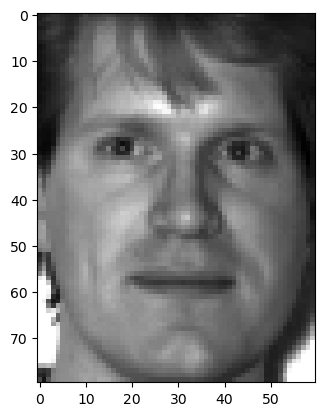

In [145]:
plt.imshow(faces_teste[0], cmap='gray');

In [146]:
ids_treino

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12,
       12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 14, 14,
       14, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 15, 15, 15])

In [147]:
len(ids_treino), len(faces_treino)

(135, 135)

In [148]:
faces_treino[0]

array([[118, 116, 108, ...,  81,  76,  70],
       [110, 127, 110, ...,  76,  83,  88],
       [ 92, 112, 100, ...,  84,  92,  88],
       ...,
       [156,  60,  29, ..., 255, 255, 255],
       [166,  96,  24, ..., 255, 255, 248],
       [164, 143,  68, ..., 255, 255, 244]], dtype=uint8)

In [149]:
faces_treino[0].shape

(80, 60)

## Modelo Eigen Faces

In [150]:
# Treinando o modelo com a base de dados 
modelo_eigen = cv2.face.EigenFaceRecognizer_create()
modelo_eigen.train(faces_treino, ids_treino)

# Salvando o modelo
modelo_eigen.write('./models/eigen_classifier.yml')

In [151]:
# Carregando o Modelo salvo
eigen_classifier = cv2.face.EigenFaceRecognizer_create()
eigen_classifier.read('./models/eigen_classifier.yml')

### Prevendo uma imagem

In [252]:
def previsao(image, classificador):
    imagem, roi = detector_facial(network, image)
    previsao, distancia = classificador.predict(roi)
    name_image = int(os.path.basename(image).split('.')[0][-2:])
        
    cv2.putText(imagem, f"Esp: {name_image}", (10,15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255), 1)
    cv2.putText(imagem, f"Pred: {previsao}", (10,30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255), 1)
    print(f'Distancia: {distancia}')
    plt.imshow(imagem, cmap='gray')
    plt.xticks(())
    plt.yticks(())
    plt.show()

3306.4875642957113


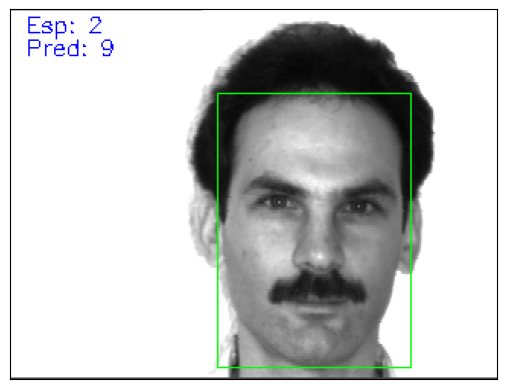

In [174]:
previsao(pasta[2], eigen_classifier)

## Avaliação do Modelo

### Previsões Base de Dados

In [175]:
def avalia_algoritmo(path, classificador):
    from sklearn.metrics import accuracy_score
    
    previsoes = list()
    distancias = list()
    saidas_esperadas = list()
    paths = [os.path.join(path, f) for f in os.listdir(path)]
    
    for path in paths:
        imagem, face = detecor_facial(network, path)
        previsao, dist = classificador.predict(face)
        previsoes.append(previsao)
        distancias.append(dist)
        saidas_esperadas.append(int(os.path.basename(path).split('.')[0][-2:]))
    
    acuracia = accuracy_score(saidas_esperadas, previsoes)
    print(f'Acurácia o modelo: \033[34m{acuracia:.3f}\033[0m')
    return previsoes, saidas_esperadas, distancias

In [176]:
previsoes,saidas_esperadas, dist = avalia_algoritmo(pasta_teste, modelo_eigen)

Acurácia o modelo: 0.700


In [177]:
print(saidas_esperadas)

[1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 12, 12, 13, 13, 14, 14, 15, 15]


In [178]:
print(previsoes)

[1, 1, 9, 9, 3, 15, 14, 4, 5, 5, 6, 8, 7, 13, 8, 2, 6, 9, 10, 10, 11, 11, 12, 12, 13, 13, 14, 14, 1, 15]


### Parametros (Ajuste de Parametros)

In [182]:
imagem_teste = pasta[1]

1706.3170605887447


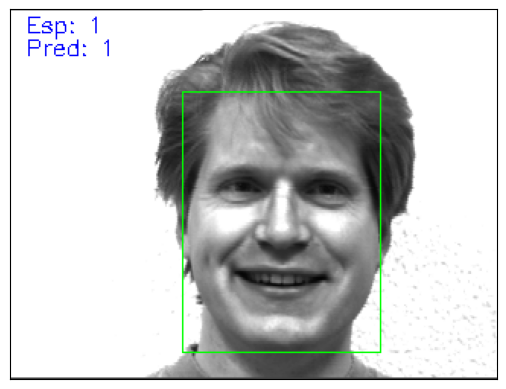

In [183]:
eigen_classifier_2 = cv2.face.EigenFaceRecognizer_create(145, 2000) # Ajustando os parametro145s
eigen_classifier_2.train(faces_treino, ids_treino)
previsao(imagem_teste, eigen_classifier_2)

In [184]:
previsoes,saidas_esperadas, dist = avalia_algoritmo(pasta_teste, eigen_classifier_2)

Acurácia o modelo: 0.467


## Modelo FishFace

In [185]:
# Treinando o modelo com a base de dados 
modelo_fish = cv2.face.FisherFaceRecognizer_create()
modelo_fish.train(faces_treino, ids_treino)

# Salvando o modelo
modelo_fish.write('./models/fisher_classifier.yml')

In [186]:
# Carregando o Modelo salvo
fisher_classifier = cv2.face.EigenFaceRecognizer_create()
fisher_classifier.read('./models/fisher_classifier.yml')

1008.7184621385172


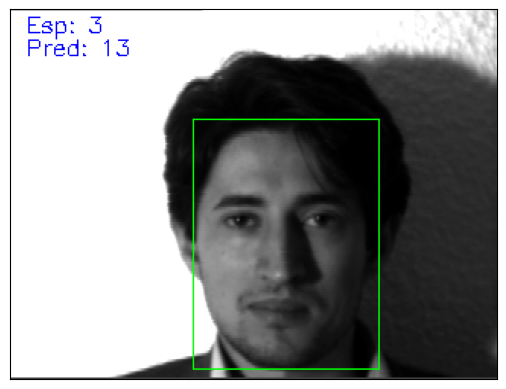

In [190]:
previsao(pasta[5], fisher_classifier)

In [191]:
previsoes,saidas_esperadas, dist = avalia_algoritmo(pasta_teste, modelo_fish)

Acurácia o modelo: 0.833


In [192]:
print(previsoes)

[1, 1, 2, 9, 3, 13, 14, 4, 5, 5, 6, 9, 7, 7, 8, 2, 9, 9, 10, 10, 11, 11, 12, 12, 13, 13, 14, 14, 15, 15]


In [193]:
print(saidas_esperadas)

[1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 12, 12, 13, 13, 14, 14, 15, 15]


### Parametros (Ajuste de Parametros)

In [233]:
fisher_classifier2 = cv2.face.FisherFaceRecognizer_create(10, 1000)
# fisher_classifier2.write('./models/fisher_classifier_0967.yml')
fisher_classifier2.train(faces_treino, ids_treino)
previsoes,saidas_esperadas, dist = avalia_algoritmo(pasta_teste, fisher_classifier2)

Acurácia o modelo: 0.967


213.8381879683236


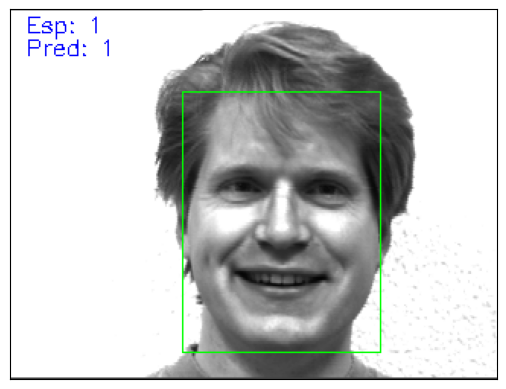

In [234]:
previsao(pasta[1], fisher_classifier2)

In [197]:
print(previsoes)

[1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 2, 9, 9, 10, 10, 11, 11, 12, 12, 13, 13, 14, 14, 15, 15]


In [198]:
print(saidas_esperadas)

[1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 12, 12, 13, 13, 14, 14, 15, 15]


## Modelo LBPH

In [243]:
# Treinando o modelo com a base de dados 
modelo_lbph = cv2.face.LBPHFaceRecognizer_create()
modelo_lbph.train(faces_treino, ids_treino)

# Salvando o modelo
# modelo_lbph.write('lbph_classifier.yml')

86.11327038056803


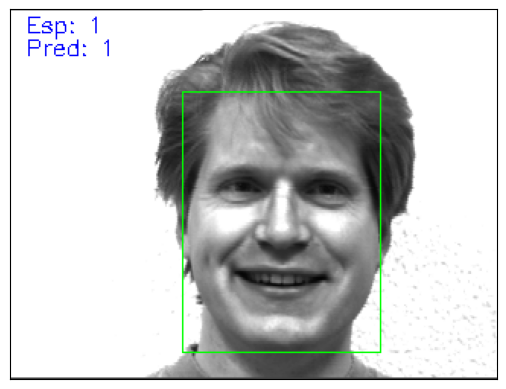

In [244]:
previsao(pasta[1], modelo_lbph)

In [245]:
previsoes,saidas_esperadas, dist = avalia_algoritmo(pasta_teste, modelo_lbph)

Acurácia o modelo: 0.800


In [246]:
print(previsoes)

[1, 1, 2, 9, 3, 3, 4, 4, 5, 5, 6, 3, 7, 7, 8, 14, 2, 9, 10, 10, 11, 11, 12, 2, 13, 13, 14, 14, 6, 15]


In [247]:
print(saidas_esperadas)

[1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 12, 12, 13, 13, 14, 14, 15, 15]


### Parametros (Ajuste de Parametros)

Acurácia o modelo: 0.833
Distancia: 30.629225362738076


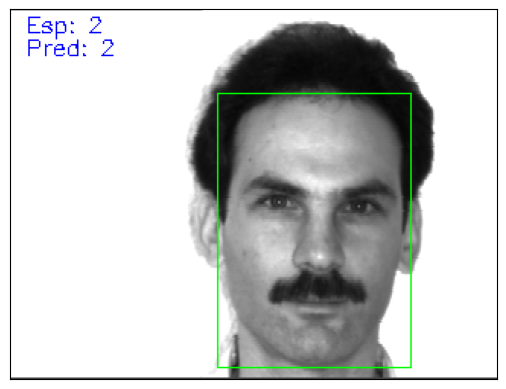

In [300]:
lbph_classifier= cv2.face.LBPHFaceRecognizer_create(threshold=50, radius=1, neighbors=3, grid_x=8, grid_y=8)
lbph_classifier.train(faces_treino, ids_treino)
previsoes,saidas_esperadas, dist = avalia_algoritmo(pasta_teste, lbph_classifier)
previsao(pasta[2], lbph_classifier)

# Salvando o modelo
# modelo_lbph.write('lbph_classifier.yml')